# Results for paper: TITLE

In [29]:
from openfermion import get_sparse_operator
from scipy.sparse.linalg import eigsh
from pathlib import Path
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry
import json
import pickle

# Function to diagonalise small hamiltonians to get the ground state
def ground(hamiltonian):
    sparse_ham = get_sparse_operator(hamiltonian)
    eigenvalue, _ = eigsh(sparse_ham, k=1, which='SA')
    return eigenvalue[0]

# Look for an xyz file for a specified molecule
def find_and_save(mol_name):
    if Path(f'./molecular_structures/{mol_name}.xyz').exists():
        print(f'xyz file for {mol_name} already exists.\n')
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    print('Molecule geometry:')
    print(geo_dict)
    save_ordered_xyz_file(mol_name, geo_dict, [0])
    print(f'xyz file for {mol_name} created.\n')


def print_results(result, active):
    
    print(f"Qubits\t\t{result[active]['mu']['n_qubits']}/{result[active]['huz']['n_qubits']}/{result['full']['n_qubits']}")
    print(f"Terms\t\t{result[active]['mu']['terms']}/{result[active]['huz']['terms']}/{result['full']['terms']}")
    print(f'DFT:\t\t{result["e_dft"]}')
    #print(f"CCSD Emb:\t{result['mu']['e_ccsd']}/{result['huz']['e_ccsd']}")
    print(f"Mu Emb:\t\t{result[active]['mu']['ground']}")
    print(f"Huz Emb:\t{result[active]['huz']['ground']}")
    print(f"Diagonalized:\t{result['full']['ground']}")
    print("\n")


def save_data(result, mol_name, localisation, force: bool):
    savefile = f'data/{mol_name}_{localisation}'

    with open(savefile + '.json', 'w') as f:
        json.dump(result, f, indent=4)
        print(f'{savefile}.json created.')


    

In [ ]:
# acetonitrile
# N-methylmethanamine
# acetaldehyde
# formamide
# ethanamine
# ethanol
# methoxymethane
# fluoroethane
# acetone
# Isopropyl alcohol 

find_and_save('Isopropyl alcohol')

In [5]:
import os
# get xyz file
notebook_dir = os.getcwd()
mol_structures_dir = os.path.join(notebook_dir, 'molecular_structures')

In [3]:
from nbed.mol_plot import Draw_molecule

file =  os.path.join(mol_structures_dir, 'Isopropyl alcohol.xyz') 

with open(file, 'r') as f:
    xyz = f.read()

print(xyz)

viewer = Draw_molecule(xyz, width=400, height=400, style='sphere')
viewer.show()

12
 
O	-0.0004	1.3572	-0.1242
C	0	0.0177	0.3601
C	-1.2599	-0.6878	-0.1179
C	1.2603	-0.6871	-0.1179
H	-0.0001	0.0646	1.454
H	-1.3079	-1.7139	0.259
H	-2.1507	-0.1484	0.2213
H	-1.3061	-0.7138	-1.2122
H	1.3089	-1.7132	0.259
H	2.1508	-0.1471	0.2213
H	1.3066	-0.7131	-1.2122
H	-0.0006	1.3242	-1.0961



You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json
from pyscf import cc

localisation = ['spade','mullikan','boys','ipo']

# Need to build paths to xyz files.
max_atoms = 3

def get_results(mol_name, active_atoms, localisation='pipek-mezey', qubits=None, force=True):
    savefile = f'data/{mol_name}_{localisation}'
    if Path(savefile+'.json').exists() and not force:
        in_string = input(f"Do you want to overwrite the saved data for {mol_name} [y]/n")
        if in_string != "y":
            print("Not saving.")
            return
    
    print(f"\nGetting results for:\n\t{mol_name}\n\t{active_atoms} atoms\n\t{localisation} localisation\n")
    find_and_save(mol_name)
    geometry = f'./molecular_structures/{mol_name}.xyz'

    config = {}
    # We pass these to the driver.
    config['localization']=localisation
    config['basis']='sto-3g'
    config['xc_functional']='b3lyp'
    config['convergence']=1e-6
    config['savefile']=None
    config['charge']=0
    config['mu_level_shift']=1e6
    config['run_ccsd_emb']=False
    config['run_fci_emb']=False
    config['max_ram_memory']=8_000
    config['pyscf_print_level']=1
    
    result = {}
    result.update(config)
    transform='jordan_wigner'

    for active in range(1,1+active_atoms):
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(geometry=geometry, n_active_atoms=active, projector='both', **config)
        print("Driver finished.")
        if active == 1:
            result['full'] = {}
            result['e_dft'] = driver._global_rks.e_tot
            full_builder = HamiltonianBuilder(driver._global_hf, constant_e_shift=driver._global_hf.energy_nuc(), transform=transform)
            full_ham = full_builder.build(qubits, taper=False)
            result['full']['qham'] = HamiltonianConverter(full_ham)._intermediate

            with open(savefile + '_full.pkl', 'wb') as f:
                pickle.dump(result['full']['qham'], f)
                print(f'Pickle created.')

            result['full']['terms'] = len(full_ham.terms)
            result['full']['n_qubits'] = count_qubits(full_ham)
            result['full']['classical_energy'] = 0
            result['full']['ground'] = None
            print('Full system Hamiltonian built.')


        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(driver._mu['scf'], driver._mu['classical_energy'], transform=transform)
        qham = mu_builder.build(qubits, taper=False)
        result[active]['mu'] = {}
        result[active]['mu']['qham'] = HamiltonianConverter(qham)._intermediate
        with open(savefile + f'{active}_mu.pkl', 'wb') as f:
            pickle.dump(result[active]['mu']['qham'], f)
            print(f'Pickle created.')
    
        result[active]['mu']['terms'] = len(qham.terms)
        result[active]['mu']['n_qubits'] = count_qubits(qham)
        result[active]['mu']['classical_energy'] = driver._mu['classical_energy']
        result[active]['mu']['ground'] = None
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(driver._huzinaga['scf'], driver._huzinaga['classical_energy'], transform=transform)
        qham = huz_builder.build(qubits, taper=False)
        result[active]['huz'] = {}
        result[active]['huz']['qham'] = HamiltonianConverter(qham)._intermediate
        with open(savefile + f'{active}huz.pkl', 'wb') as f:
            pickle.dump(result[active]['mu']['qham'], f)
            print(f'Pickle created.')

        result[active]['huz']['terms'] = len(qham.terms)
        result[active]['huz']['n_qubits'] = count_qubits(qham)
        result[active]['huz']['classical_energy'] = driver._huzinaga['classical_energy']
        result[active]['huz']['ground'] = None
        print("Huzinaga finished.")


# untapered_mu = mu_builder.build(taper=False)
# untapered_huz = huz_builder.build(taper=False)
# untapered_full = full_builder.build(taper=False)
# print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
# print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
# print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")
        
        print_results(result, active)
            
    result['mol_name']=mol_name
    result['transform']=transform
    result['qubit_limit'] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result


In [32]:
get_results("cyclopentane", 5, force=False, localisation='spade')


Getting results for:
	cyclopentane
	5 atoms
	spade localisation

xyz file for cyclopentane already exists.

Starting driver with 1 active atoms.


1970-01-06 07:51:08,477: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/cyclopentane_spade.pkl created.
Full system Hamiltonian built.
data/cyclopentane_spade.pkl created.
Mu finished.
data/cyclopentane_spade.pkl created.
Huzinaga finished.
Qubits		32/32/70
Terms		94833/94833/2210438
DFT:		-194.07974854469666
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.


1970-01-06 07:59:24,645: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/cyclopentane_spade.pkl created.
Mu finished.
data/cyclopentane_spade.pkl created.
Huzinaga finished.
Qubits		40/40/70
Terms		232993/233001/2210438
DFT:		-194.07974854469666
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 3 active atoms.


1970-01-06 08:00:38,786: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/cyclopentane_spade.pkl created.
Mu finished.
data/cyclopentane_spade.pkl created.
Huzinaga finished.
Qubits		40/40/70
Terms		232957/232949/2210438
DFT:		-194.07974854469666
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 4 active atoms.


1970-01-06 08:01:50,754: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/cyclopentane_spade.pkl created.
Mu finished.
data/cyclopentane_spade.pkl created.
Huzinaga finished.
Qubits		48/48/70
Terms		485253/485245/2210438
DFT:		-194.07974854469666
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 5 active atoms.


1970-01-06 08:04:32,658: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/cyclopentane_spade.pkl created.
Mu finished.
data/cyclopentane_spade.pkl created.
Huzinaga finished.
Qubits		48/48/70
Terms		485245/485253/2210438
DFT:		-194.07974854469666
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/cyclopentane_spade.json created.




{'localization': 'spade',
 'basis': 'sto-3g',
 'xc_functional': 'b3lyp',
 'convergence': 1e-06,
 'savefile': None,
 'charge': 0,
 'mu_level_shift': 1000000.0,
 'run_ccsd_emb': False,
 'run_fci_emb': False,
 'max_ram_memory': 8000,
 'pyscf_print_level': 1,
 'full': {'qham': {'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': -115.21248844147296,
   'ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.806248985782189,
   'IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.806248985782189,
   'IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.8061545579741995,
   'IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.8061545579741995,
   'IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.804565718820283,
   'IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII': 6.804565718820283,
   'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [30]:
# acetonitrile
# N-methylmethanamine
# acetaldehyde
# formamide
# ethanamine
# ethanol
# methoxymethane
# fluoroethane
# acetone
# isopropyl_alcohol 

mols = []
for mol in mols:
    get_results(mol, 1, force=False, localisation='ibo')

mols = ['N-methylmethanamine', 'acetonitrile', 'ethanol', 'fluoroethane', 'isopropyl_alcohol']
for mol in mols:
    get_results(mol, 2, force=True, localisation='ibo')

for mol in ['ethanamine', 'formamide', 'acetaldehyde']:
    get_results(mol, 3, force=True, localisation='ibo')


Getting results for:
	N-methylmethanamine
	2 atoms
	ibo localisation

xyz file for N-methylmethanamine already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 8 iter; Final gradient 9.55e-11


1970-01-06 06:10:15,936: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/N-methylmethanamine_ibo.pkl created.
Full system Hamiltonian built.
data/N-methylmethanamine_ibo.pkl created.
Mu finished.
data/N-methylmethanamine_ibo.pkl created.
Huzinaga finished.
Qubits		20/20/44
Terms		14251/14251/338971
DFT:		-133.38541994449054
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 8 iter; Final gradient 9.55e-11


1970-01-06 06:11:18,019: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/N-methylmethanamine_ibo.pkl created.
Mu finished.
data/N-methylmethanamine_ibo.pkl created.
Huzinaga finished.
Qubits		22/22/44
Terms		20838/20838/338971
DFT:		-133.38541994449054
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/N-methylmethanamine_ibo.json created.



Getting results for:
	acetonitrile
	2 atoms
	ibo localisation

xyz file for acetonitrile already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.43e-09


1970-01-06 06:11:34,579: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/acetonitrile_ibo.pkl created.
Full system Hamiltonian built.
data/acetonitrile_ibo.pkl created.
Mu finished.
data/acetonitrile_ibo.pkl created.
Huzinaga finished.
Qubits		16/16/36
Terms		5793/5793/136067
DFT:		-130.98422068212892
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.43e-09


1970-01-06 06:12:06,404: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/acetonitrile_ibo.pkl created.
Mu finished.
data/acetonitrile_ibo.pkl created.
Huzinaga finished.
Qubits		26/26/36
Terms		34620/34708/136067
DFT:		-130.98422068212892
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/acetonitrile_ibo.json created.



Getting results for:
	ethanol
	2 atoms
	ibo localisation

xyz file for ethanol already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.75e-09


1970-01-06 06:12:28,249: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/ethanol_ibo.pkl created.
Full system Hamiltonian built.
data/ethanol_ibo.pkl created.
Mu finished.
data/ethanol_ibo.pkl created.
Huzinaga finished.
Qubits		20/20/42
Terms		14243/14243/283020
DFT:		-152.92496376312693
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.75e-09


1970-01-06 06:13:22,042: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/ethanol_ibo.pkl created.
Mu finished.
data/ethanol_ibo.pkl created.
Huzinaga finished.
Qubits		24/24/42
Terms		29737/29737/283020
DFT:		-152.92496376312693
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/ethanol_ibo.json created.



Getting results for:
	fluoroethane
	2 atoms
	ibo localisation

xyz file for fluoroethane already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.49e-09


1970-01-06 06:13:41,364: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/fluoroethane_ibo.pkl created.
Full system Hamiltonian built.
data/fluoroethane_ibo.pkl created.
Mu finished.
data/fluoroethane_ibo.pkl created.
Huzinaga finished.
Qubits		22/22/40
Terms		19702/19710/217385
DFT:		-176.54744199402683
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.49e-09


1970-01-06 06:14:28,290: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/fluoroethane_ibo.pkl created.
Mu finished.
data/fluoroethane_ibo.pkl created.
Huzinaga finished.
Qubits		26/26/40
Terms		38180/38164/217385
DFT:		-176.54744199402683
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/fluoroethane_ibo.json created.



Getting results for:
	isopropyl_alcohol
	2 atoms
	ibo localisation

xyz file for isopropyl_alcohol already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 8 iter; Final gradient 9.11e-10


1970-01-06 06:14:50,487: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/isopropyl_alcohol_ibo.pkl created.
Full system Hamiltonian built.
data/isopropyl_alcohol_ibo.pkl created.
Mu finished.
data/isopropyl_alcohol_ibo.pkl created.
Huzinaga finished.
Qubits		26/26/56
Terms		40004/40012/874321
DFT:		-191.7473895604452
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 8 iter; Final gradient 9.11e-10


1970-01-06 06:17:28,992: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/isopropyl_alcohol_ibo.pkl created.
Mu finished.
data/isopropyl_alcohol_ibo.pkl created.
Huzinaga finished.
Qubits		30/30/56
Terms		71414/70818/874321
DFT:		-191.7473895604452
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/isopropyl_alcohol_ibo.json created.



Getting results for:
	ethanamine
	3 atoms
	ibo localisation

xyz file for ethanamine already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.28e-09


1970-01-06 06:18:02,062: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/ethanamine_ibo.pkl created.
Full system Hamiltonian built.
data/ethanamine_ibo.pkl created.
Mu finished.
data/ethanamine_ibo.pkl created.
Huzinaga finished.
Qubits		22/22/44
Terms		20530/20530/329283
DFT:		-133.38678777854375
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.28e-09


1970-01-06 06:19:06,247: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/ethanamine_ibo.pkl created.
Mu finished.
data/ethanamine_ibo.pkl created.
Huzinaga finished.
Qubits		24/24/44
Terms		29737/29737/329283
DFT:		-133.38678777854375
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 2.28e-09


1970-01-06 06:19:25,526: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/ethanamine_ibo.pkl created.
Mu finished.
data/ethanamine_ibo.pkl created.
Huzinaga finished.
Qubits		26/26/44
Terms		40028/40100/329283
DFT:		-133.38678777854375
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/ethanamine_ibo.json created.



Getting results for:
	formamide
	3 atoms
	ibo localisation

xyz file for formamide already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.89e-09


1970-01-06 06:19:47,180: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/formamide_ibo.pkl created.
Full system Hamiltonian built.
data/formamide_ibo.pkl created.
Mu finished.
data/formamide_ibo.pkl created.
Huzinaga finished.
Qubits		14/14/36
Terms		3366/3366/138235
DFT:		-167.5024800790768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.89e-09


1970-01-06 06:20:20,068: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/formamide_ibo.pkl created.
Mu finished.
data/formamide_ibo.pkl created.
Huzinaga finished.
Qubits		22/22/36
Terms		18370/18370/138235
DFT:		-167.5024800790768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.89e-09


1970-01-06 06:20:37,162: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/formamide_ibo.pkl created.
Mu finished.
data/formamide_ibo.pkl created.
Huzinaga finished.
Qubits		24/24/36
Terms		26769/26769/138235
DFT:		-167.5024800790768
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/formamide_ibo.json created.



Getting results for:
	acetaldehyde
	3 atoms
	ibo localisation

xyz file for acetaldehyde already exists.

Starting driver with 1 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.03e-09


1970-01-06 06:20:55,656: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/acetaldehyde_ibo.pkl created.
Full system Hamiltonian built.
data/acetaldehyde_ibo.pkl created.
Mu finished.
data/acetaldehyde_ibo.pkl created.
Huzinaga finished.
Qubits		16/16/38
Terms		5781/5781/182702
DFT:		-151.72459696811134
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.03e-09


1970-01-06 06:21:33,928: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/acetaldehyde_ibo.pkl created.
Mu finished.
data/acetaldehyde_ibo.pkl created.
Huzinaga finished.
Qubits		24/24/38
Terms		28745/28745/182702
DFT:		-151.72459696811134
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


Starting driver with 3 active atoms.
 Iterative localization: IB/P4/2x2, 7 iter; Final gradient 1.03e-09


1970-01-06 06:21:53,895: nbed.driver: WARNING: Outputting both mu and huzinaga embedding results as tuple.


Driver finished.
data/acetaldehyde_ibo.pkl created.
Mu finished.
data/acetaldehyde_ibo.pkl created.
Huzinaga finished.
Qubits		28/28/38
Terms		54011/54167/182702
DFT:		-151.72459696811134
Mu Emb:		None
Huz Emb:	None
Diagonalized:	None


data/acetaldehyde_ibo.json created.




In [36]:
with open('data/cyclopentane_spade.json', 'r') as f:
    cyclopropane = json.load(f)

In [37]:
whole_dft = cyclopropane['e_dft']
active_atoms = range(1,6)
cp_qubits = [cyclopropane[str(i)]['mu']['n_qubits'] for i in active_atoms]
cp_terms = [cyclopropane[str(i)]['mu']['terms'] for i in active_atoms]

In [38]:
full_terms = cyclopropane['full']['terms']
full_n_qubits = cyclopropane['full']['n_qubits']

NameError: name 'energies' is not defined

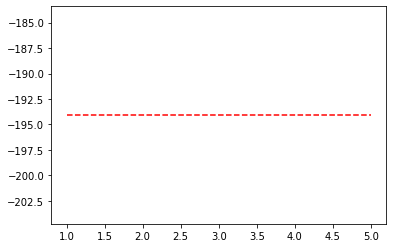

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.hlines(whole_ccsd, min(active_atoms), max(active_atoms), colors='blue', linestyle='dashed', label='CCSD')
ax.hlines(whole_dft, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label='DFT')
ax.plot(active_atoms, energies, label='Huzinaga CCSD Embedding')
ax.set_xlabel('Active Carbon Atoms')
ax.set_ylabel('Energy (Ha)')
ax.set_xticks(active_atoms)
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel('Number of Qubits Used')
ax2.hlines(full_n_qubits, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label=f'Full system: {full_n_qubits}')
ax2.plot(active_atoms, cp_qubits, linestyle='solid', color='red', label='n qubits')
ax.hlines(full_terms, min(active_atoms), max(active_atoms), colors='blue', linestyle='dotted', label=f'Full system: {full_terms}')
ax.plot(active_atoms, cp_terms, linestyle='solid', color='blue', label='terms')
ax.set_xlabel('Active Carbon Atoms')
ax.set_xticks(active_atoms)
ax.set_ylabel('Number of Terms')
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

In [34]:
# Extract data from the results json files

from pathlib import Path
import json


data = {}
for file in Path("../data/").iterdir():
    if "spade" in file.name:
        continue
    
    with open(file, 'r') as f:
        file_data = json.load(f)

    mol_name = file_data['mol_name']
    data[mol_name] = file_data
    data[mol_name]['full'].pop('qham')

    for i in range(5):
        n_data = data[mol_name].get(str(i), False)
        if n_data:
            n_data['huz'].pop('qham')
            n_data['mu'].pop('qham')

# Filters out anything too big to get the embedded ground state
data = {key: data[key] for key in sorted(data) if data[key]['1']['mu']['ground']}

FileNotFoundError: [Errno 2] No such file or directory: '../results'

In [33]:
import pandas as pd
df = pd.DataFrame(data).T

NameError: name 'data' is not defined

In [ ]:
full_vals = pd.DataFrame(df['full'].to_list(), index=df['mol_name'])
one_mu = pd.DataFrame([v['mu'] for v in df['1'].to_list()], index=df['mol_name'])
one_huz = pd.DataFrame([v['huz'] for v in df['1'].to_list()], index=df['mol_name'])

In [ ]:
with open('data/cyclopropane_spade.json', 'r') as f:
    propane = json.load(f)

In [ ]:
import numpy as np
mol_names = df['mol_name'].to_list()
full_vals = df['full'].to_list()
ccsd_vals = df['e_ccsdt'].to_list()

full_qubits = np.array([v['n_qubits'] for v in full_vals])
full_terms = np.array([v['terms'] for v in full_vals])

act_1 = df['1'].to_list()
mu_vals_1 = [v['mu'] for v in act_1]
huz_vals_1 = [v['huz'] for v in act_1]
mu_qubits_1 = np.array([v['mu']['n_qubits'] for v in act_1])
mu_terms_1 = [v['mu']['terms'] for v in act_1 if type(v) is dict]
huz_qubits_1 = np.array([v['huz']['n_qubits'] for v in act_1])
huz_terms_1 = [v['huz']['terms'] for v in act_1 if type(v) is dict]

act_2 = df['2'].to_list()
mu_vals_2 = [v['mu'] for v in act_2]
huz_vals_2 = [v['huz'] for v in act_2]
mu_qubits_2 = np.array([v['mu']['n_qubits'] for v in act_2])
mu_terms_2 = [v['mu']['terms'] for v in act_2 if type(v) is dict]
huz_qubits_2 = np.array([v['huz']['n_qubits'] for v in act_2])
huz_terms_2 = [v['huz']['terms'] for v in act_2 if type(v) is dict]

In [ ]:
energies_full = [v['ground'] if v['ground'] is not None else 0 for v in full_vals]
energies_dft = [v['e_dft'] if v['e_dft'] is not None else 0 for v in data.values()]
energies_mu = [v['ground'] if v['ground'] is not None else 0 for v in mu_vals_1]
energies_huz = [v['ground'] if v['ground'] is not None else 0 for v in huz_vals_1]

energies_full = np.array(energies_full)
energies_dft = np.array(energies_dft)
energies_mu = np.array(energies_mu)
energies_huz = np.array(energies_huz)
energies_ccsd = np.array(ccsd_vals)

dft_diffs = [100*(dft -ccsd)/ccsd if (dft and ccsd) else 0 for dft, ccsd in zip(energies_dft, energies_ccsd)]
mu_diffs = [100*(v -ccsd)/ccsd if (v and ccsd)  else 0 for v, ccsd in zip(energies_mu, energies_ccsd)]
huz_diffs = [100*(v -ccsd)/ccsd if (v and ccsd) else 0 for v, ccsd in zip(energies_huz, energies_ccsd)]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(mol_names))  # the label locations
width = 0.1  # the width of the bars

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12,9))
def_es = ax1.bar(x + width, dft_diffs, width, label='DFT')
mu_es = ax1.bar(x, mu_diffs, width, label='$\mu$-shift')
huz_es = ax1.bar(x - width, huz_diffs, width, label='Huzinaga')

full_qubs = ax2.bar(x + width, full_qubits, width, label='Full system')
mu_qubs = ax2.bar(x, mu_qubits_1, width, label='$\mu$-shift')
huz_qubs = ax2.bar(x - width, huz_qubits_1, width, label='Huzinaga')

full_qubs = ax3.bar(x + width, full_terms, width, label='Full system')
mu_qubs = ax3.bar(x, mu_terms_1, width, label='$\mu$-shift')
huz_qubs = ax3.bar(x - width, huz_terms_1, width, label='Huzinaga')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel("% Error from CCSD(T)")
ax1.set_title('Molecular ground state energies.')
ax1.set_xticks(x)
ax1.set_xticklabels(mol_names)
#ax1.tick_params(axis="x", rotation=50)
ax1.legend()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel("Qubits")
ax2.set_title('Number of qubits in Hamiltonian.')
ax2.set_xticks(x)
ax2.set_xticklabels(mol_names)
ax2.tick_params(axis="x", rotation=50)
ax2.legend()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel("Terms.")
ax3.set_title('Number of terms in Hamiltonian.')
ax3.set_xticks(x)
ax3.set_xticklabels(mol_names)
ax3.tick_params(axis="x", rotation=50)
ax3.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for ax in fig.get_axes():
    ax.label_outer()

# autolabel(rects3)
# autolabel(rects2)

fig.tight_layout()
plt.show()

## General Params 
threshold
basis
xc functional


## Small molecules

One for SPADE
One for IBO
Molecule, active atoms(AOs), dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)


Graphs:
Bar graph of molecules energies, hamiltonian size
Cyclic molecule: terms / qubits, energy
bonus: compare molecular orbitals


## H4
One for different numbers of active atoms 1-3
Angle, dft energy, embedding (huz/mu), full_system: fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)

## Water
Bond length, dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)